## Libraries

In [1]:
import pandas as pd
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression


## Map features and labels

In [2]:
# Extract and read eeg_features.csv
with open('eeg_features.csv') as eeg_file:
    eeg_features = pd.read_csv(eeg_file)

# Extract and read Stress-feedbacks.csv
with open('labels-sam40.csv') as feedbacks_file:
    stress_feedbacks = pd.read_csv(feedbacks_file)

if not stress_feedbacks['Id'].str.endswith('.csv').all():
    stress_feedbacks['Id'] = stress_feedbacks['Id'].apply(lambda x: x + '.csv')
# Perform the join operation
merged_df = pd.merge(eeg_features, stress_feedbacks[['Id', 'Stress-level']], left_on='file', right_on='Id').drop(columns=['Id'])

Convert the original feedback (0 for relax and 1-10 for stress ratings) into categorical labels: no stress (0), low stress (1-5), and stress (6-10).


In [3]:
# Map the Stress-level values to Labels
merged_df['Labels'] = merged_df['Stress-level'].apply(lambda x: 0 if x == 0 else (1 if 1 <= x <= 5 else 2))

# Drop the old Stress-level column
merged_df = merged_df.drop(columns=['Stress-level'])

In [4]:
# Save the head of the merged dataframe to a CSV file
merged_df.to_csv('features-labels.csv', index=False)

## ANOVA feature selection 

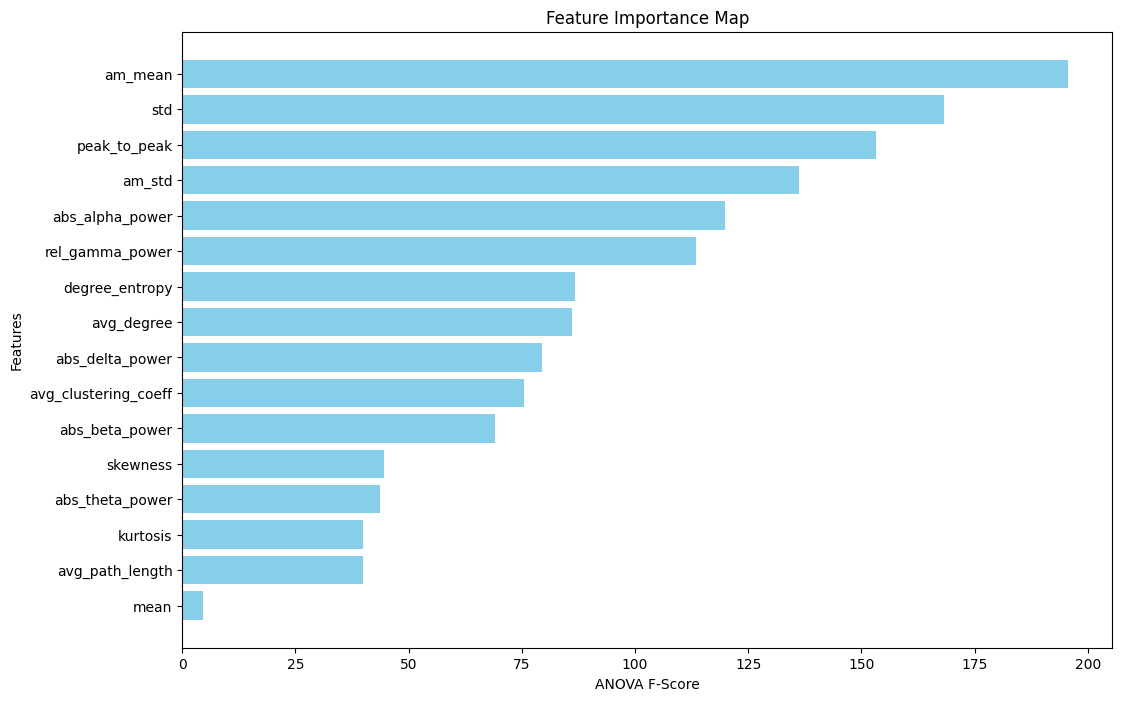

In [5]:
# Load the dataset
data = pd.read_csv('features-labels.csv')

# Separate features and labels
X = data.iloc[:, 3:-1]  # Exclude the first three columns and the last column
y = data['Labels']

# Perform ANOVA F-test
selector = SelectKBest(score_func=f_classif, k='all')
X_new = selector.fit_transform(X, y)

# Get the scores for each feature
scores = selector.scores_

# Create a DataFrame for the scores
feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': scores})

# Sort the features by score
feature_scores = feature_scores.sort_values(by='Score', ascending=False)

# Plot the feature importance map
plt.figure(figsize=(12, 8))
plt.barh(feature_scores['Feature'], feature_scores['Score'], color='skyblue')
plt.xlabel('ANOVA F-Score')
plt.ylabel('Features')
plt.title('Feature Importance Map')
plt.gca().invert_yaxis()
plt.show()

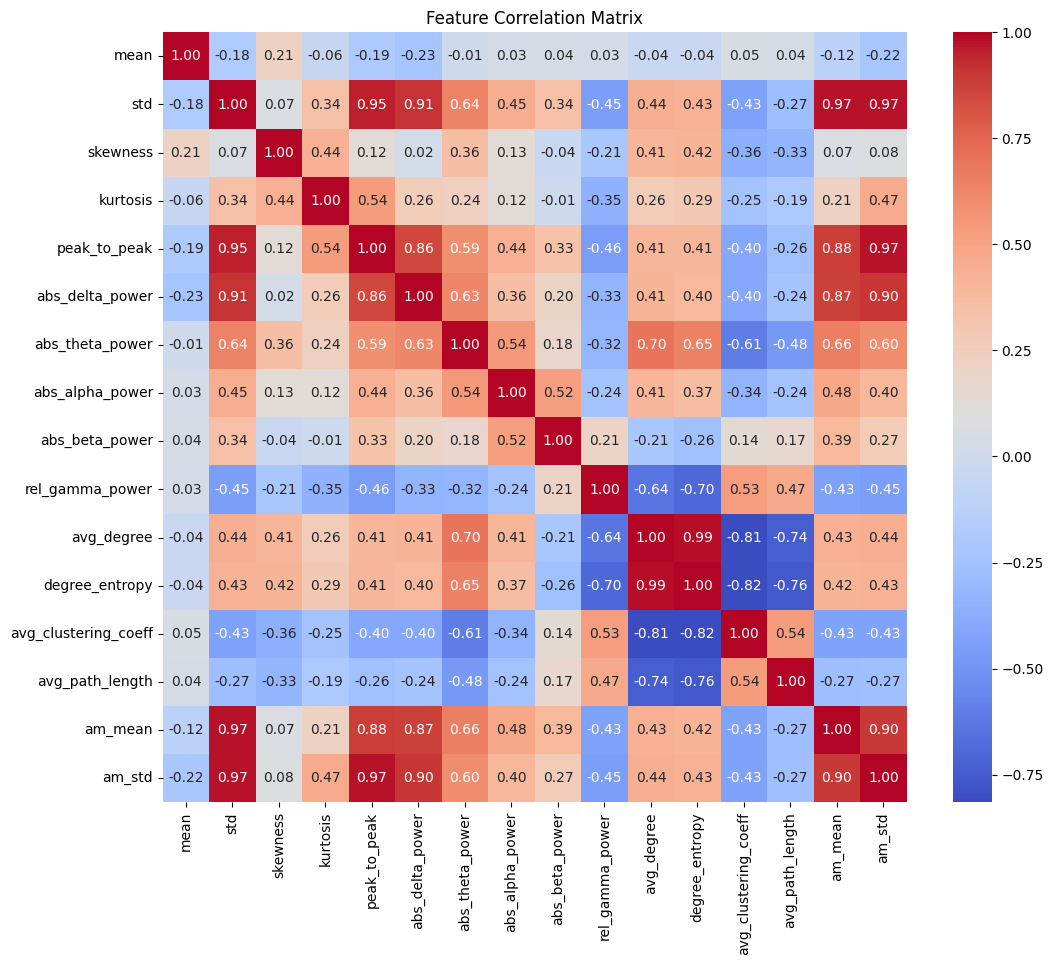

In [6]:
import seaborn as sns

# Compute the correlation matrix
correlation_matrix = X.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

## Recursive Feature Elimination (RFE)

/Users/marioroca/stess-detection-sam40/sam40/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/marioroca/stess-detection-sam40/sam40/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

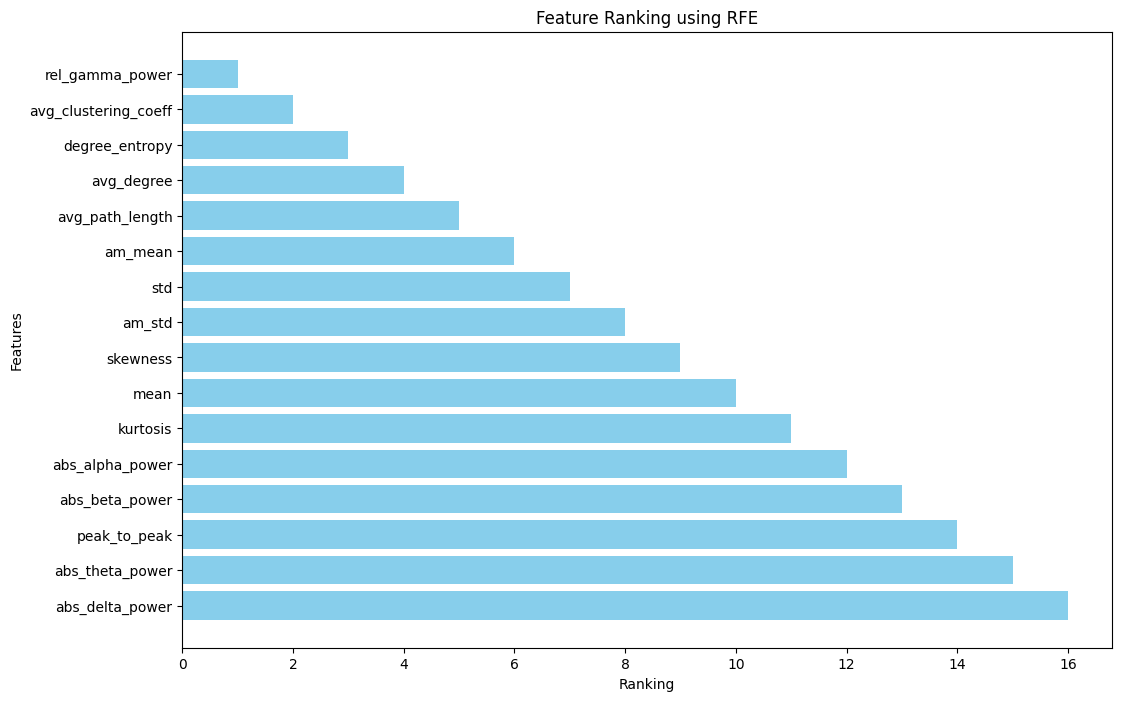

In [7]:
# Initialize the model
model = LogisticRegression(max_iter=1000)

# Initialize RFE with the model and the number of features to select
rfe = RFE(estimator=model, n_features_to_select=1)

# Fit RFE
rfe.fit(X, y)

# Get the ranking of the features
ranking = rfe.ranking_

# Create a DataFrame for the rankings
feature_ranking = pd.DataFrame({'Feature': X.columns, 'Ranking': ranking})

# Sort the features by ranking
feature_ranking = feature_ranking.sort_values(by='Ranking')

# Plot the feature ranking
plt.figure(figsize=(12, 8))
plt.barh(feature_ranking['Feature'], feature_ranking['Ranking'], color='skyblue')
plt.xlabel('Ranking')
plt.ylabel('Features')
plt.title('Feature Ranking using RFE')
plt.gca().invert_yaxis()
plt.show()